In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
#import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
#dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = '/home/olivia/mothML/mothMachineLearning_dataAndFigs/Figs/'
dataOutput = '/home/olivia/mothML/mothMachineLearning_dataAndFigs/DataOutput/'
savedModels = '/home/olivia/mothML/mothMachineLearning_dataAndFigs/savedModels/'
dataDir = '/home/olivia/mothML/mothMachineLearning_dataAndFigs/PythonGeneratedData_oneTorque/'

if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0] 

last run on 2021-02-05 16:16:33.984485


In [2]:
tf.__version__

'2.0.0'

In [3]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Make training and test set

In [5]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [6]:
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)
con1.close()

In [7]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [8]:
print(trainDF.shape)
trainDF.head()

(10000000, 19)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0
0,0.0,1127.569064,0.0,765.895323,1.075898,11.962440,3.427385,18.462602,18.323331,716.627905,14.965420,553.784155,2.653195,147.068401,5.115222,153.187791,41181.992912,1.987846,-63216.237665
1,0.0,979.651081,0.0,-625.561275,0.306688,-5.637037,2.576453,19.788635,18.603118,878.261004,-13.758388,-732.267264,0.102441,-34.254744,2.372751,-34.214230,9062.020340,3.567122,19108.940596
2,0.0,1111.257777,0.0,-1406.672066,5.094943,16.102668,1.775724,-9.188076,19.014000,1058.629029,-25.108839,-1007.321715,2.811424,-218.672246,-0.370204,-211.787743,42727.993224,4.104033,49781.327507
3,0.0,-1438.730397,0.0,690.882986,5.034187,-3.375327,5.534301,-9.669100,-31.101504,-1501.738112,10.625933,331.290367,6.319507,141.205184,6.795796,140.443097,28953.145279,4.698031,92261.347215
4,0.0,1370.322727,0.0,-216.459775,4.186927,-16.500337,3.194818,-0.385905,27.276171,1358.779274,-4.544002,-238.613391,3.984840,-10.035763,3.181642,-0.756667,371.601599,0.668810,-40259.257246


In [9]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [10]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)


In [11]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# make test dataset
Xtest = testDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Ytest = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [12]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,3.427385,1.075898,18.323331,14.965420,5.115222,2.653195,1127.569064,765.895323,18.462602,11.962440
1,2.576453,0.306688,18.603118,-13.758388,2.372751,0.102441,979.651081,-625.561275,19.788635,-5.637037
2,1.775724,5.094943,19.014000,-25.108839,-0.370204,2.811424,1111.257777,-1406.672066,-9.188076,16.102668
3,5.534301,5.034187,-31.101504,10.625933,6.795796,6.319507,-1438.730397,690.882986,-9.669100,-3.375327
4,3.194818,4.186927,27.276171,-4.544002,3.181642,3.984840,1370.322727,-216.459775,-0.385905,-16.500337


In [13]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-16681.383440,37652.197635,-63216.237665,716.627905,553.784155,153.187791,147.068401
1,-8253.874132,-3740.825371,19108.940596,878.261004,-732.267264,-34.214230,-34.254744
2,-24419.876370,-35062.102662,49781.327507,1058.629029,-1007.321715,-211.787743,-218.672246
3,-415.702991,-28950.160838,92261.347215,-1501.738112,331.290367,140.443097,141.205184
4,291.543841,230.412537,-40259.257246,1358.779274,-238.613391,-0.756667,-10.035763


In [14]:
# val train split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [15]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xval_scaled = scalerX.transform(Xval)
Yval_scaled = scalerY.transform(Yval)


# final test data
Xtest_scaled = scalerX.transform(Xtest)

In [16]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.440808,-0.497541,-0.376881,-0.092528,0.279106,-0.125546,-0.413733,-0.087276,0.151751,-0.419563
1,0.002656,0.450960,0.232234,0.301146,-0.030380,0.180345,0.276074,0.383212,0.227138,0.094672
2,0.302116,0.217276,0.364791,-0.175444,-0.008066,-0.047502,0.385703,-0.188919,-0.266187,-0.202705
3,-0.471247,0.121804,0.070077,0.310735,-0.319397,-0.062783,0.103501,0.332100,-0.227711,0.447327
4,-0.350056,-0.349031,0.313582,0.159721,-0.093290,-0.092005,0.350805,0.216431,0.136925,0.270457


### Preparing the data

In [17]:
def get_dataset(Xtrain_scaled, Ytrain_scaled, Xval_scaled, Yval_scaled, Xtest_scaled, Ytest):
    batch_size = (2**10)
    return (
        tf.data.Dataset.from_tensor_slices((Xtrain_scaled, Ytrain_scaled)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((Xval_scaled, Yval_scaled)).batch(batch_size),
        tf.data.Dataset.from_tensor_slices((Xtest_scaled, Ytest)).batch(batch_size),
    )

train_dataset, val_dataset, test_dataset = get_dataset(Xtrain_scaled, Ytrain_scaled, Xval_scaled, Yval_scaled, Xtest_scaled, Ytest)

# Keras models

In [17]:
# import
#from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
#from keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Keras callcacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

### Defining the strategy

In [19]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2",'/gpu:3'],
cross_device_ops=tf.distribute.NcclAllReduce()
)

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 4


In [18]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    #K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization),use_bias=True)(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh',use_bias=True)(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear',use_bias=True)(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [19]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

# Adjusting early stop from 0.000001 to 0.0001 to try to make my plot look more like Callin's 
earlystop = EarlyStopping(monitor='val_mse', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.00001)

In [20]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history.history['val_mean_squared_error']), 50), 50)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
    


    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(16,8))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'], alpha = 0.7)
    axs.set_title('Learning curve for sequential pruning')
    axs.set_ylabel('Mean squared error')
    #Callin's plot titles
    #'Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1]))
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history_dictionary['val_mean_squared_error']), 50),50)
    axs.legend(['train', 'validation'], loc=2)
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))


___

### Model creation and compilation should happen within strategy 

In [21]:
modelParams = {"optimizer": 'rmsprop',
"dropout_rate" : 0,
"numUnits": [400, 400, 400, 16],
"weightRegularization": 0
}

#Multi-GPU
#with strategy.scope():
#    model = create_network(**modelParams)

#Single GPU
model = create_network(**modelParams)

modeltimestamp = datetime.now().strftime("%Y_%m_%d__%I_%M_%S")
modelName = ''.join('{}*{}__'.format(key[0:3].capitalize(), val) for key, val in modelParams.items()).\
replace("[", "").replace("]", "").replace(", ", "*")[0:-2] + "_" + modeltimestamp

modelSubdir = os.path.join(dataOutput, modeltimestamp)
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

print(modelName)

model.summary()

Opt*rmsprop__Dro*0__Num*400*400*400*16__Wei*0_2021_01_25__10_07_47
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 400)               4400      
_________________________________________________________________
dense_1 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 119       
Total params: 331,735
Trainable params: 331,735
Non-trainabl

In [22]:
# save scalers, to be used on test set

scalerSubdir = os.path.join(modelSubdir, 'scalers')
if not os.path.exists(scalerSubdir):
    os.mkdir(scalerSubdir)
    
scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerX, open(os.path.join(scalerSubdir, scalerfileX), 'wb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerY, open(os.path.join(scalerSubdir, scalerfileY), 'wb'))

In [23]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [24]:
import time

In [25]:
start_time = time.time()

#Training with single GPU
history = model.fit(Xtrain_scaled, Ytrain_scaled,
    validation_data=(Xval_scaled, Yval_scaled),
    callbacks = [earlystop],
    verbose = 2, batch_size=2**12, epochs = 1000)

#Training with multiple GPUs
#history = model.fit(train_dataset,
#    validation_data=val_dataset,
#    callbacks = [earlystop],
#    verbose = 2, epochs = 1000)

print("--- %s seconds ---" % (time.time() - start_time))

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1000
8000000/8000000 - 47s - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 2/1000
8000000/8000000 - 45s - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 3/1000
8000000/8000000 - 45s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/1000
8000000/8000000 - 45s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 5/1000
8000000/8000000 - 45s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 6/1000
8000000/8000000 - 45s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/1000
8000000/8000000 - 45s - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 8/1000
8000000/8000000 - 45s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 9/1000
8000000/8000000 - 45s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 10/1000
8000000/8000000 - 45s -

Epoch 75/1000
8000000/8000000 - 45s - loss: 6.3385e-04 - mse: 6.3385e-04 - val_loss: 6.0706e-04 - val_mse: 6.0706e-04
Epoch 76/1000
8000000/8000000 - 45s - loss: 6.3033e-04 - mse: 6.3033e-04 - val_loss: 6.8082e-04 - val_mse: 6.8082e-04
Epoch 77/1000
8000000/8000000 - 45s - loss: 6.2736e-04 - mse: 6.2736e-04 - val_loss: 6.8617e-04 - val_mse: 6.8618e-04
Epoch 78/1000
8000000/8000000 - 45s - loss: 6.2317e-04 - mse: 6.2317e-04 - val_loss: 7.2339e-04 - val_mse: 7.2339e-04
Epoch 79/1000
8000000/8000000 - 45s - loss: 6.1983e-04 - mse: 6.1983e-04 - val_loss: 5.8087e-04 - val_mse: 5.8087e-04
Epoch 80/1000
8000000/8000000 - 45s - loss: 6.1705e-04 - mse: 6.1705e-04 - val_loss: 5.8969e-04 - val_mse: 5.8969e-04
Epoch 81/1000
8000000/8000000 - 45s - loss: 6.1346e-04 - mse: 6.1345e-04 - val_loss: 7.4473e-04 - val_mse: 7.4473e-04
Epoch 82/1000
8000000/8000000 - 45s - loss: 6.0987e-04 - mse: 6.0987e-04 - val_loss: 5.4907e-04 - val_mse: 5.4907e-04
Epoch 83/1000
8000000/8000000 - 45s - loss: 6.0753e-04 -

8000000/8000000 - 45s - loss: 4.8976e-04 - mse: 4.8976e-04 - val_loss: 6.1276e-04 - val_mse: 6.1276e-04
Epoch 145/1000
8000000/8000000 - 45s - loss: 4.8760e-04 - mse: 4.8759e-04 - val_loss: 5.3621e-04 - val_mse: 5.3621e-04
Epoch 146/1000
8000000/8000000 - 45s - loss: 4.8629e-04 - mse: 4.8629e-04 - val_loss: 5.5289e-04 - val_mse: 5.5289e-04
Epoch 147/1000
8000000/8000000 - 45s - loss: 4.8533e-04 - mse: 4.8533e-04 - val_loss: 4.0907e-04 - val_mse: 4.0907e-04
Epoch 148/1000
8000000/8000000 - 45s - loss: 4.8448e-04 - mse: 4.8448e-04 - val_loss: 3.8683e-04 - val_mse: 3.8683e-04
Epoch 149/1000
8000000/8000000 - 45s - loss: 4.8372e-04 - mse: 4.8372e-04 - val_loss: 5.9425e-04 - val_mse: 5.9425e-04
Epoch 150/1000
8000000/8000000 - 45s - loss: 4.8143e-04 - mse: 4.8143e-04 - val_loss: 6.1968e-04 - val_mse: 6.1968e-04
Epoch 151/1000
8000000/8000000 - 45s - loss: 4.8130e-04 - mse: 4.8129e-04 - val_loss: 6.5710e-04 - val_mse: 6.5710e-04
Epoch 152/1000
8000000/8000000 - 45s - loss: 4.7951e-04 - mse: 

Epoch 213/1000
8000000/8000000 - 45s - loss: 4.2841e-04 - mse: 4.2841e-04 - val_loss: 5.2162e-04 - val_mse: 5.2162e-04
Epoch 214/1000
8000000/8000000 - 45s - loss: 4.2736e-04 - mse: 4.2736e-04 - val_loss: 4.2409e-04 - val_mse: 4.2409e-04
Epoch 215/1000
8000000/8000000 - 45s - loss: 4.2684e-04 - mse: 4.2684e-04 - val_loss: 4.7003e-04 - val_mse: 4.7003e-04
Epoch 216/1000
8000000/8000000 - 45s - loss: 4.2675e-04 - mse: 4.2675e-04 - val_loss: 3.4945e-04 - val_mse: 3.4945e-04
Epoch 217/1000
8000000/8000000 - 45s - loss: 4.2562e-04 - mse: 4.2562e-04 - val_loss: 4.3702e-04 - val_mse: 4.3702e-04
Epoch 218/1000
8000000/8000000 - 45s - loss: 4.2531e-04 - mse: 4.2531e-04 - val_loss: 4.6175e-04 - val_mse: 4.6175e-04
Epoch 219/1000
8000000/8000000 - 45s - loss: 4.2457e-04 - mse: 4.2457e-04 - val_loss: 4.8913e-04 - val_mse: 4.8913e-04
Epoch 220/1000
8000000/8000000 - 45s - loss: 4.2451e-04 - mse: 4.2451e-04 - val_loss: 3.9253e-04 - val_mse: 3.9253e-04
Epoch 221/1000
8000000/8000000 - 45s - loss: 4.2

In [26]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


In [27]:
# save history
historyDict["mean_squared_error"].extend(history.history['mse'])
historyDict["val_mean_squared_error"].extend(history.history['val_mse'])

/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


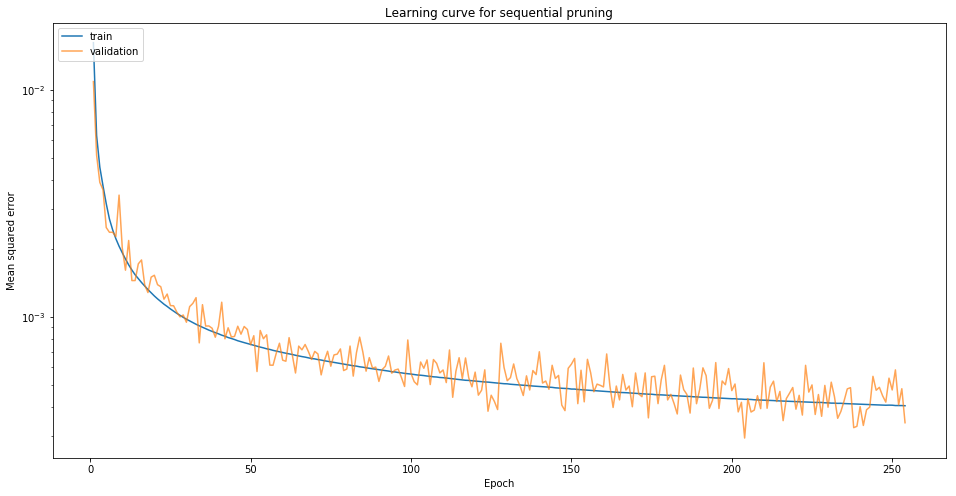

In [28]:
plot_model_history_fromDict(historyDict)
plt.show()

In [29]:
# save model
model.save(os.path.join(modelSubdir,  modelName + '.h5'))

#Original weights sub directory
weightsOGSubdir = os.path.join(modelSubdir, 'originalWeights')
if not os.path.exists(weightsOGSubdir):
    os.mkdir(weightsOGSubdir)

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(weightsOGSubdir, wtsFile), 'wb'))

# save history with same name as model
historyFile = modeltimestamp + '_original_history.pkl'
pickle.dump(historyDict, open(os.path.join(modelSubdir, historyFile), 'wb'))

In [30]:
#  plot error rates on test data

In [ ]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()


In [42]:
print("Evaluate on test data")
results = model.evaluate(Xtest_scaled, Ytest, batch_size=128)
print("test loss, test mse:", results)

Evaluate on test data
5000000/5000000 [==============================] - 63s 13us/sample - loss: 569732153.6979 - mean_squared_error: 569736448.0000
test loss, test mse: [569732153.6978945, 569736450.0]


In [44]:
#df_c = df_c.iloc[:1000, :]

# df_c = df_c.replace([np.inf, -np.inf], np.nan)
# df_c = df_c.replace([np.inf, -np.inf], np.nan).dropna()

In [50]:
import matplotlib.ticker as mtick
import matplotlib
class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            return(" ")
        return "${}$".format(s)

NameError: name 'df_c' is not defined

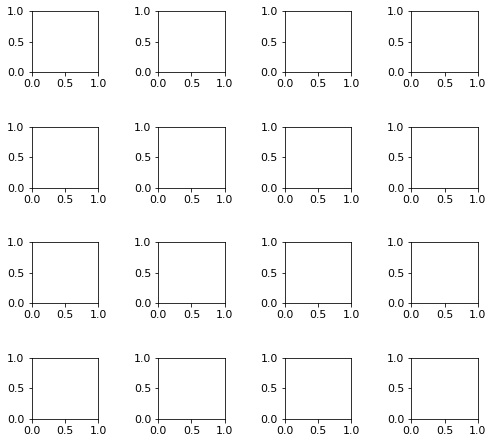

In [51]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.2)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.2)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.85, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.48,0.48], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
#fig.savefig(os.path.join(figDir, "PredVActual" + modelName + ".pdf"),)
plt.show()
# plt.close()

## Callin's Pruning Algorithm

In [19]:
# load model
from tensorflow.keras.models import load_model

modelName =  'Opt*rmsprop__Dro*0__Num*400*400*400*16__Wei*0_2020_11_25__07_53_11'
modeltimestamp = "2020_11_25__07_53_11"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

# load weights
wtsFile = modelName + '_wts.pkl'
wts = pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

# load history with same name as model
historyFile = modeltimestamp + '_history.pkl'
historyDict = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))


/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


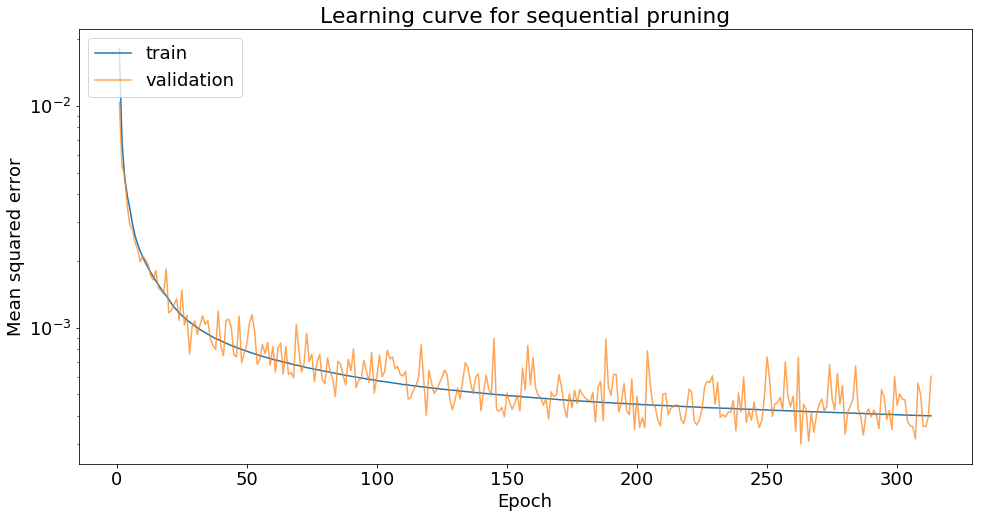

In [20]:
plt.rcParams.update({'font.size': 18})
plot_model_history_fromDict(historyDict)

plt.show()

In [21]:
# train with pruning
numCuts = 1

wts = model.get_weights()
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

In [22]:
# make new folder to save each prune
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpointsCS_v2")
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

#### Callin's original pruning percentages: 

In [100]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)

# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

print(cutPercent)

[ 0.          7.93242521 15.47534606 22.31218051 28.24497764 33.20183851
 37.21384337 40.37844583 42.82424577 44.68488636 46.08342772 47.12515041
 47.8958653  48.46322944 48.87935937 49.18374288 49.40594778 49.56792665
 49.68587867 49.77170471 49.83411989 49.87949158 49.91246404 49.9364206
 49.95382384 49.96646499]


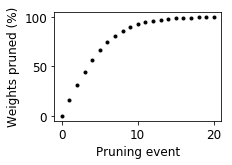

In [62]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[3,2])
plt.plot((cutPercent*2)[0:21], ".", color = "black")
plt.xlabel("Pruning event")
plt.ylabel("Weights pruned (%)")
plt.savefig(os.path.join(figDir, "pruningPercentages.pdf"), bbox_inches='tight')

#### More natural pruning percentages: 

In [23]:
cutPercent = [0, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.90]
cutPercent = np.append(cutPercent, np.arange(0.91, 0.99, 0.01))
cutPercent = 100*cutPercent/2
print(cutPercent)

[ 0.   7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 45.  45.5 46.  46.5 47.
 47.5 48.  48.5 49. ]


cutPercent must be *100/2 (percentiles, not decimals) 

In [ ]:
overallEpochCounter = len(historyDict['mean_squared_error'])
print(overallEpochCounter)

firstPrune = True

while True:   
   
    for numEpocs in range(100):
        
        if firstPrune == True:
            MSE_tmp = []
            history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)       
            firstPrune = False
            
        else:
            MSE_tmp = []
            model = load_model(os.path.join(savedModels, modelSubdir, modelName + '_Pruned.h5'))
            history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)       
        
        overallEpochCounter += 1
        
        # save history
        historyDict["mean_squared_error"].extend(history.history["mse"])
        historyDict["val_mean_squared_error"].extend(history.history["val_mse"])
        
        # local MSE
        MSE_tmp.append(history.history["mse"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), 
                                    q = (50 - cutPercent[numCuts], 
                                        50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        model.save(os.path.join(savedModels,  modelSubdir, modelName + '_Pruned.h5'))
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mse"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                
                # save model
                #model.save(os.path.join(savedModels,  modelSubdir, modelName + '_Pruned.h5'))
                
            
                # save weights
                wts = model.get_weights().copy()

                wtsFile = str(overallEpochCounter) + "_" + modelName + '_wts.pkl'
                pickle.dump(wts, open(os.path.join(savedModels, modelSubdir, wtsFile), 'wb'))

                
                # save history with same name as model
                historyFile = modeltimestamp + '_history.pkl'
                pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))
                
                numCuts += 1                
                break
                
            #else:
                # save model
                #model.save(os.path.join(savedModels,  modelSubdir, modelName + '_Pruned.h5'))


    if numCuts >= len(cutPercent):
        break


313
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.9965e-04 - mse: 3.9965e-04 - val_loss: 4.3540e-04 - val_mse: 4.3540e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.9937e-04 - mse: 3.9936e-04 - val_loss: 4.5003e-04 - val_mse: 4.5003e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 9s - loss: 3.9927e-04 - mse: 3.9927e-04 - val_loss: 5.3847e-04 - val_mse: 5.3847e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 9s - loss: 3.9892e-04 - mse: 3.9892e-04 - val_loss: 4.3276e-04 - val_mse: 4.3276e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 3.9880e-04 - mse: 3.9880e-04 - val_loss: 3.8055e-04 - val_mse: 3.8055e-04
281976 of 331735 weights retained
Train on 8000000 samples, validate on 

8000000/8000000 - 11s - loss: 3.8969e-04 - mse: 3.8969e-04 - val_loss: 3.7593e-04 - val_mse: 3.7593e-04
149282 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.8932e-04 - mse: 3.8932e-04 - val_loss: 4.1594e-04 - val_mse: 4.1594e-04
149282 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 3.8925e-04 - mse: 3.8925e-04 - val_loss: 4.1495e-04 - val_mse: 4.1495e-04
149282 of 331735 weights retained
change in log loss: -0.0007513523101809749
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
************************************************ PRUNING ********************************************************
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.8902e-0

49764 of 331735 weights retained
change in log loss: -0.0032643318176271974
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.1274e-04 - mse: 4.1274e-04 - val_loss: 4.4415e-04 - val_mse: 4.4415e-04
49764 of 331735 weights retained
change in log loss: -0.0027791976928712714
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.1216e-04 - mse: 4.1217e-04 - val_loss: 4.3889e-04 - val_mse: 4.3889e-04
49764 of 331735 weights retained
change in log loss: -0.0025139808654788265
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.1068e-04 - mse: 4.1068e-04 - val_loss: 4.8786e-04 - val_mse: 4.8786e-04
49764 of 331735 weights retained
change in log loss: -0.0026743888854983133
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.1001e-04 - mse: 4.1001e-04 - val_loss: 3.1245e-04 - val_mse: 3.1245e-04
49764 of 331735 weights retained
change in log loss: -0.00269956

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 3.9385e-04 - mse: 3.9385e-04 - val_loss: 3.7167e-04 - val_mse: 3.7167e-04
49764 of 331735 weights retained
change in log loss: -0.0005661487579348146
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.9364e-04 - mse: 3.9364e-04 - val_loss: 2.8635e-04 - val_mse: 2.8635e-04
49764 of 331735 weights retained
change in log loss: -0.0003159523010256571
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 3.9254e-04 - mse: 3.9254e-04 - val_loss: 3.2010e-04 - val_mse: 3.2010e-04
49764 of 331735 weights retained
change in log loss: -0.0009586811065676049
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 3.9221e-04 - mse: 3.9221e-04 - val_loss: 4.3204e-04 - val_mse: 4.3204e-04
49764 of 331735 weights retained
change in log loss: -0.0012925624847415218
Train on 8000000 samples, validate on 2000000 samples
8000000/80

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6931e-04 - mse: 4.6931e-04 - val_loss: 3.2690e-04 - val_mse: 3.2690e-04
33176 of 331735 weights retained
change in log loss: -0.012646245956421165
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6609e-04 - mse: 4.6609e-04 - val_loss: 3.3523e-04 - val_mse: 3.3523e-04
33176 of 331735 weights retained
change in log loss: -0.01093335151672381
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6509e-04 - mse: 4.6509e-04 - val_loss: 3.4307e-04 - val_mse: 3.4307e-04
33176 of 331735 weights retained
change in log loss: -0.007781791687011985
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6250e-04 - mse: 4.6250e-04 - val_loss: 5.3246e-04 - val_mse: 5.3246e-04
33176 of 331735 weights retained
change in log loss: -0.005834007263183838
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000

29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.6863e-04 - mse: 6.6863e-04 - val_loss: 4.5033e-04 - val_mse: 4.5034e-04
29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.1899e-04 - mse: 6.1899e-04 - val_loss: 5.9250e-04 - val_mse: 5.9250e-04
29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.0048e-04 - mse: 6.0048e-04 - val_loss: 3.7463e-04 - val_mse: 3.7463e-04
29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.8695e-04 - mse: 5.8695e-04 - val_loss: 5.0465e-04 - val_mse: 5.0465e-04
29858 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 12s - loss: 5.7948e-04 - mse: 5.7948e-04 - val_loss: 4.0600e-04 - val_mse: 4.0600e-04
29858 of 331735 weights retained
Train on 800

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0179e-04 - mse: 5.0179e-04 - val_loss: 4.5210e-04 - val_mse: 4.5210e-04
29858 of 331735 weights retained
change in log loss: -0.0015700340270997648
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0216e-04 - mse: 5.0216e-04 - val_loss: 5.4054e-04 - val_mse: 5.4054e-04
29858 of 331735 weights retained
change in log loss: -0.0016821384429932529
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0055e-04 - mse: 5.0055e-04 - val_loss: 4.0738e-04 - val_mse: 4.0738e-04
29858 of 331735 weights retained
change in log loss: -0.0028073787689211205
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.9903e-04 - mse: 4.9903e-04 - val_loss: 5.5921e-04 - val_mse: 5.5921e-04
29858 of 331735 weights retained
change in log loss: -0.002642297744751221
Train on 8000000 samples, validate on 2000000 samples
8000000/800

8000000/8000000 - 11s - loss: 4.6731e-04 - mse: 4.6731e-04 - val_loss: 4.7676e-04 - val_mse: 4.7676e-04
29858 of 331735 weights retained
change in log loss: -0.0016606330871583586
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6782e-04 - mse: 4.6782e-04 - val_loss: 3.6559e-04 - val_mse: 3.6559e-04
29858 of 331735 weights retained
change in log loss: -0.0013108730316164774
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6536e-04 - mse: 4.6536e-04 - val_loss: 4.3906e-04 - val_mse: 4.3906e-04
29858 of 331735 weights retained
change in log loss: -0.002041530609131037
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6504e-04 - mse: 4.6504e-04 - val_loss: 5.5711e-04 - val_mse: 5.5711e-04
29858 of 331735 weights retained
change in log loss: -0.0022235870361330123
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6386e-04 - mse: 4.6387e-04 - val_

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.5810e-04 - mse: 4.5810e-04 - val_loss: 3.8148e-04 - val_mse: 3.8148e-04
26542 of 331735 weights retained
change in log loss: -0.001113224029541282
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.5740e-04 - mse: 4.5740e-04 - val_loss: 3.1839e-04 - val_mse: 3.1839e-04
26542 of 331735 weights retained
change in log loss: -0.0011243820190433018
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.5588e-04 - mse: 4.5588e-04 - val_loss: 5.5657e-04 - val_mse: 5.5657e-04
26542 of 331735 weights retained
change in log loss: -0.0011247634887697755
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.5482e-04 - mse: 4.5482e-04 - val_loss: 4.9063e-04 - val_mse: 4.9063e-04
26542 of 331735 weights retained
change in log loss: -0.0015936374664310415
Train on 8000000 samples, validate on 2000000 samples
8000000/800

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.7884e-04 - mse: 5.7884e-04 - val_loss: 5.3039e-04 - val_mse: 5.3039e-04
23224 of 331735 weights retained
change in log loss: -0.005294466018676891
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.7531e-04 - mse: 5.7531e-04 - val_loss: 5.1993e-04 - val_mse: 5.1993e-04
23224 of 331735 weights retained
change in log loss: -0.005398464202880926
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.7235e-04 - mse: 5.7235e-04 - val_loss: 5.4074e-04 - val_mse: 5.4074e-04
23224 of 331735 weights retained
change in log loss: -0.005402612686157382
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.6872e-04 - mse: 5.6872e-04 - val_loss: 4.5777e-04 - val_mse: 4.5777e-04
23224 of 331735 weights retained
change in log loss: -0.005946683883667037
Train on 8000000 samples, validate on 2000000 samples
8000000/800000

8000000/8000000 - 10s - loss: 5.0948e-04 - mse: 5.0948e-04 - val_loss: 4.5280e-04 - val_mse: 4.5280e-04
23224 of 331735 weights retained
change in log loss: -0.001280593872070579
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.0651e-04 - mse: 5.0651e-04 - val_loss: 7.6382e-04 - val_mse: 7.6382e-04
23224 of 331735 weights retained
change in log loss: -0.002013158798218062
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0695e-04 - mse: 5.0695e-04 - val_loss: 4.5821e-04 - val_mse: 4.5821e-04
23224 of 331735 weights retained
change in log loss: -0.0018794059753420855
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.0529e-04 - mse: 5.0529e-04 - val_loss: 3.7933e-04 - val_mse: 3.7933e-04
23224 of 331735 weights retained
change in log loss: -0.002348709106445579
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.0422e-04 - mse: 5.0422e-04 - val_lo

23224 of 331735 weights retained
change in log loss: -0.0011513233184817784
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.8265e-04 - mse: 4.8265e-04 - val_loss: 5.7395e-04 - val_mse: 5.7395e-04
23224 of 331735 weights retained
change in log loss: -0.0014035701751712315
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.8167e-04 - mse: 4.8167e-04 - val_loss: 4.4336e-04 - val_mse: 4.4336e-04
23224 of 331735 weights retained
change in log loss: -0.0018101215362551493
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.8234e-04 - mse: 4.8234e-04 - val_loss: 4.8760e-04 - val_mse: 4.8760e-04
23224 of 331735 weights retained
change in log loss: -0.0009604454040529342
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.8091e-04 - mse: 4.8091e-04 - val_loss: 4.2738e-04 - val_mse: 4.2738e-04
23224 of 331735 weights retained
change in log loss: -0.00081033

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6817e-04 - mse: 4.6817e-04 - val_loss: 5.4391e-04 - val_mse: 5.4391e-04
23224 of 331735 weights retained
change in log loss: -0.0006112575531008746
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6821e-04 - mse: 4.6820e-04 - val_loss: 3.8344e-04 - val_mse: 3.8344e-04
23224 of 331735 weights retained
change in log loss: -0.0006302356719972702
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6732e-04 - mse: 4.6732e-04 - val_loss: 4.0057e-04 - val_mse: 4.0057e-04
23224 of 331735 weights retained
change in log loss: -0.0012076854705811435
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6823e-04 - mse: 4.6823e-04 - val_loss: 3.7164e-04 - val_mse: 3.7164e-04
23224 of 331735 weights retained
change in log loss: -0.0007507324218751776
Train on 8000000 samples, validate on 2000000 samples
8000000/80

19908 of 331735 weights retained
change in log loss: -0.0007723331451415794
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6944e-04 - mse: 4.6944e-04 - val_loss: 4.8677e-04 - val_mse: 4.8677e-04
19908 of 331735 weights retained
change in log loss: -0.0008431434631348544
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6890e-04 - mse: 4.6890e-04 - val_loss: 3.7868e-04 - val_mse: 3.7867e-04
19908 of 331735 weights retained
change in log loss: -0.0007742404937746139
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 4.6814e-04 - mse: 4.6814e-04 - val_loss: 4.0383e-04 - val_mse: 4.0383e-04
19908 of 331735 weights retained
change in log loss: -0.0009941101074220082
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 4.6757e-04 - mse: 4.6757e-04 - val_loss: 5.2499e-04 - val_mse: 5.2499e-04
19908 of 331735 weights retained
change in log loss: -0.00092015

16590 of 331735 weights retained
change in log loss: -0.005749797821045122
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.6938e-04 - mse: 6.6938e-04 - val_loss: 4.8238e-04 - val_mse: 4.8238e-04
16590 of 331735 weights retained
change in log loss: -0.005189180374145841
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.6495e-04 - mse: 6.6495e-04 - val_loss: 4.9722e-04 - val_mse: 4.9722e-04
16590 of 331735 weights retained
change in log loss: -0.004685831069946578
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.5994e-04 - mse: 6.5994e-04 - val_loss: 5.3401e-04 - val_mse: 5.3401e-04
16590 of 331735 weights retained
change in log loss: -0.005378723144531472
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.5814e-04 - mse: 6.5814e-04 - val_loss: 5.0541e-04 - val_mse: 5.0541e-04
16590 of 331735 weights retained
change in log loss: -0.005352735519

Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.2388e-04 - mse: 6.2388e-04 - val_loss: 4.6836e-04 - val_mse: 4.6837e-04
16590 of 331735 weights retained
change in log loss: -0.0012181758880616123
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.2246e-04 - mse: 6.2246e-04 - val_loss: 5.2750e-04 - val_mse: 5.2750e-04
16590 of 331735 weights retained
change in log loss: -0.0007829666137696423
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.2149e-04 - mse: 6.2149e-04 - val_loss: 5.6734e-04 - val_mse: 5.6734e-04
16590 of 331735 weights retained
change in log loss: -0.0013176441192628285
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.2116e-04 - mse: 6.2116e-04 - val_loss: 5.6883e-04 - val_mse: 5.6883e-04
16590 of 331735 weights retained
change in log loss: -0.0014010429382325107
Train on 8000000 samples, validate on 2000000 samples
8000000/80

8000000/8000000 - 10s - loss: 6.0222e-04 - mse: 6.0222e-04 - val_loss: 5.1242e-04 - val_mse: 5.1242e-04
16590 of 331735 weights retained
change in log loss: -0.0017095088958741789
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.0301e-04 - mse: 6.0301e-04 - val_loss: 5.5136e-04 - val_mse: 5.5136e-04
16590 of 331735 weights retained
change in log loss: -0.0012545108795167792
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.0225e-04 - mse: 6.0225e-04 - val_loss: 4.5930e-04 - val_mse: 4.5930e-04
16590 of 331735 weights retained
change in log loss: -0.0007349967956544745
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.0119e-04 - mse: 6.0119e-04 - val_loss: 4.6900e-04 - val_mse: 4.6900e-04
16590 of 331735 weights retained
change in log loss: -0.0009628772735598146
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.0086e-04 - mse: 6.0086e-04 - val

16590 of 331735 weights retained
change in log loss: -0.0004689216613772418
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.8740e-04 - mse: 5.8740e-04 - val_loss: 5.2339e-04 - val_mse: 5.2339e-04
16590 of 331735 weights retained
change in log loss: -0.0002623081207278055
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 5.8705e-04 - mse: 5.8705e-04 - val_loss: 6.0259e-04 - val_mse: 6.0259e-04
16590 of 331735 weights retained
change in log loss: -0.0005418777465823199
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.8679e-04 - mse: 5.8679e-04 - val_loss: 4.7285e-04 - val_mse: 4.7285e-04
16590 of 331735 weights retained
change in log loss: -0.00047144889831562953
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 5.8667e-04 - mse: 5.8667e-04 - val_loss: 5.3790e-04 - val_mse: 5.3790e-04
16590 of 331735 weights retained
change in log loss: -0.0004887

13274 of 331735 weights retained
change in log loss: -0.003232717514038419
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.2639e-04 - mse: 6.2639e-04 - val_loss: 5.4337e-04 - val_mse: 5.4337e-04
13274 of 331735 weights retained
change in log loss: -0.002847957611084362
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.2474e-04 - mse: 6.2474e-04 - val_loss: 5.3309e-04 - val_mse: 5.3309e-04
13274 of 331735 weights retained
change in log loss: -0.0028728961944582965
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 11s - loss: 6.2382e-04 - mse: 6.2382e-04 - val_loss: 5.4802e-04 - val_mse: 5.4802e-04
13274 of 331735 weights retained
change in log loss: -0.002213048934936679
Train on 8000000 samples, validate on 2000000 samples
8000000/8000000 - 10s - loss: 6.2205e-04 - mse: 6.2205e-04 - val_loss: 4.7688e-04 - val_mse: 4.7688e-04
13274 of 331735 weights retained
change in log loss: -0.00251798629

In [ ]:
print(history.history.keys())

In [ ]:
historyFile = modeltimestamp + '_CallinPruned_history_new_tf_v.pkl'
pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))

In [ ]:
# get cut points
savedChecks = [f for f in os.listdir(os.path.join(savedModels, modelSubdir)) if f.endswith('wts.pkl')]
vlines = [int(savedChecks[ii][0:4].replace("_", "")) for ii in range(len(savedChecks)) if savedChecks[ii][0].isdigit()]

In [68]:
vlines.sort()
vlines.insert(0, 476) # this is the first cut  -- not saved
vlines

[476,
 352,
 359,
 366,
 373,
 381,
 393,
 417,
 451,
 493,
 561,
 653,
 735,
 828,
 905,
 1095,
 1160,
 1279,
 1307,
 1360,
 1378,
 1421,
 1490,
 1560,
 1575,
 1596]

In [69]:
list(zip(vlines, [np.round(cutPercent[jj+1]*2, 2) for jj in  range(len(vlines))]))

IndexError: index 26 is out of bounds for axis 0 with size 26

In [ ]:
plt.rcParams.update({'font.size': 16})
plot_model_history_fromDict(historyDict)

'''
for vline in vlines:
    plt.vlines(vline+1, ymin = 0, ymax = historyDict["mean_squared_error"][0], alpha = 0.5, linewidth = 0.9)

plt.ylim(10**-3.7, 10**-1.1)
plt.title("")

for jj in [0,7,9, 10,12, 14,16,18, 19]:
    s = str(np.round(cutPercent[jj+1]*2, 2)) + "%"
    plt.plot(vlines[jj], 10**-1.75, "v", color = "black")
    plt.text(vlines[jj], 10**-1.75, s,{'ha': 'left', 'va': 'bottom'}, fontsize=14, rotation=45)
plt.savefig(os.path.join(figDir, "ModelPruning_" + modelName + ".pdf"), bbox_inches='tight')
'''
plt.show()

In [61]:
## Reload model with 80% of connections pruned and evaluate error

In [62]:
K.clear_session()


modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_27__01_30_06572_Pruned"
modeltimestamp = "2020_01_27__01_30_06"
model = load_model(os.path.join(savedModels, modelSubdir,  modelName + ".h5"))

--------------------------------------------------------------------------------------------------------------

# Pruning with Tensorflow Model Optimization Toolkit

## Prune fixed amount of initial model
(rather than the sequential pruning)

In [30]:
from tensorflow.keras.models import load_model

import tensorflow_model_optimization as tfmot

import tempfile
import os

In [31]:
modelName

'Opt*rmsprop__Dro*0__Num*400*400*400*16__Wei*0_2021_01_25__10_07_47'

In [32]:
modelName = 'Opt*rmsprop__Dro*0__Num*400*400*400*16__Wei*0_2021_01_18__12_24_09'
modeltimestamp = "2021_01_18__12_24_09"
model = load_model(os.path.join(modelSubdir,  modelName + ".h5"))

# load history with same name as model
historyFile = modeltimestamp + '_original_history.pkl'
historyDict = pickle.load(open(os.path.join(modelSubdir, historyFile), 'rb'))

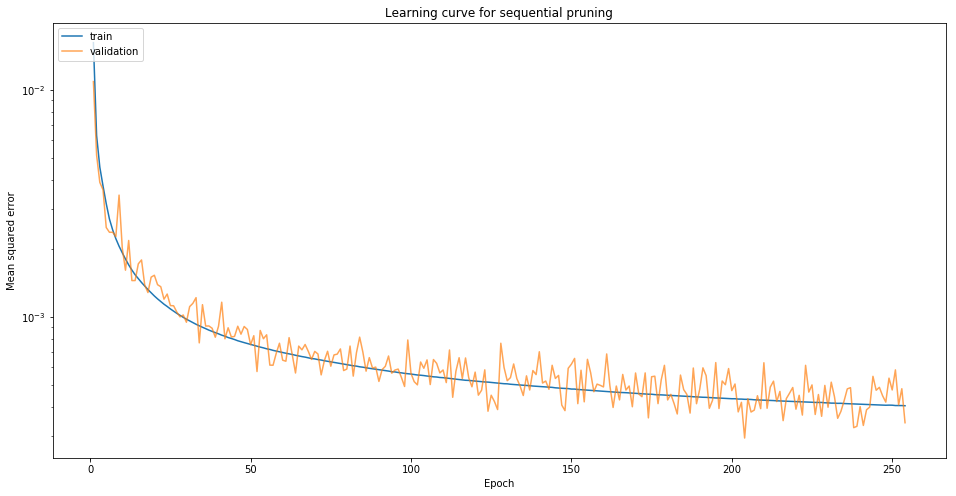

In [32]:
plot_model_history_fromDict(historyDict)
plt.show()

In [33]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
ConstantSparsity = tfmot.sparsity.keras.ConstantSparsity

### Define pruning parameters 

In [34]:
def define_pruning_params(percent_pruned):
    '''
    '''
    
    pruning_params = {
        'pruning_schedule': ConstantSparsity(percent_pruned,0),
        'block_size': (1,1),
        'block_pooling_type': 'AVG'
    }
    
    return(pruning_params)

### Create model for pruning

In [35]:
def create_pruned_model(model, 
                        pruning_params,
                        optimizer = 'rmsprop'):

    '''
    '''
    
    pruned_model = prune_low_magnitude(model, **pruning_params)
    
    pruned_model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])
    
    return(pruned_model)

In [36]:
logdir = tempfile.mkdtemp()

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir = logdir),
    earlystop,

]

In [28]:
pruning_params = define_pruning_params(0.85)
pruned_model = create_pruned_model(model, pruning_params)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [29]:
pruned_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 400)               8402      
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 400)               320402    
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 400)               320402    
_________________________________________________________________
prune_low_magnitude_dense_3  (None, 16)                12818     
_________________________________________________________________
prune_low_magnitude_dense_4  (None, 7)                 233       
Total params: 662,257
Trainable params: 331,735
Non-trainable params: 330,522
_________________________________________________

In [30]:
start_time = time.time()


pruned_history = pruned_model.fit(Xtrain_scaled, Ytrain_scaled, 
                                  validation_data=(Xval_scaled, Yval_scaled),
                                  callbacks = callbacks,
                                  verbose = 2, batch_size=2**12, epochs = 500)


print("--- %s seconds ---" % (time.time() - start_time))

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 13s - loss: 4.6037e-04 - mse: 4.6037e-04 - val_loss: 3.8767e-04 - val_mse: 3.8767e-04
Epoch 2/500
8000000/8000000 - 11s - loss: 3.7895e-04 - mse: 3.7895e-04 - val_loss: 3.3278e-04 - val_mse: 3.3278e-04
Epoch 3/500
8000000/8000000 - 11s - loss: 3.6801e-04 - mse: 3.6801e-04 - val_loss: 3.2597e-04 - val_mse: 3.2597e-04
Epoch 4/500
8000000/8000000 - 11s - loss: 3.6228e-04 - mse: 3.6228e-04 - val_loss: 4.1441e-04 - val_mse: 4.1441e-04
Epoch 5/500
8000000/8000000 - 11s - loss: 3.5939e-04 - mse: 3.5939e-04 - val_loss: 3.2906e-04 - val_mse: 3.2906e-04
Epoch 6/500
8000000/8000000 - 11s - loss: 3.5563e-04 - mse: 3.5563e-04 - val_loss: 3.3741e-04 - val_mse: 3.3741e-04
Epoch 7/500
8000000/8000000 - 11s - loss: 3.5322e-04 - mse: 3.5322e-04 - val_loss: 3.5129e-04 - val_mse: 3.5129e-04
Epoch 8/500
8000000/8000000 - 11s - loss: 3.5182e-04 - mse: 3.5182e-04 - val_loss: 3.8337e-04 - val_mse: 3.8337e-04
Epoch 9/500
800000

Epoch 71/500
8000000/8000000 - 11s - loss: 3.2359e-04 - mse: 3.2359e-04 - val_loss: 3.0476e-04 - val_mse: 3.0476e-04
Epoch 72/500
8000000/8000000 - 11s - loss: 3.2331e-04 - mse: 3.2331e-04 - val_loss: 3.5359e-04 - val_mse: 3.5359e-04
Epoch 73/500
8000000/8000000 - 11s - loss: 3.2364e-04 - mse: 3.2364e-04 - val_loss: 3.0256e-04 - val_mse: 3.0256e-04
Epoch 74/500
8000000/8000000 - 11s - loss: 3.2280e-04 - mse: 3.2280e-04 - val_loss: 3.3418e-04 - val_mse: 3.3418e-04
Epoch 75/500
8000000/8000000 - 11s - loss: 3.2301e-04 - mse: 3.2301e-04 - val_loss: 3.2067e-04 - val_mse: 3.2067e-04
Epoch 76/500
8000000/8000000 - 11s - loss: 3.2298e-04 - mse: 3.2298e-04 - val_loss: 3.7168e-04 - val_mse: 3.7168e-04
Epoch 77/500
8000000/8000000 - 11s - loss: 3.2217e-04 - mse: 3.2217e-04 - val_loss: 3.6559e-04 - val_mse: 3.6559e-04
Epoch 78/500
8000000/8000000 - 11s - loss: 3.2226e-04 - mse: 3.2226e-04 - val_loss: 3.6660e-04 - val_mse: 3.6660e-04
Epoch 79/500
8000000/8000000 - 11s - loss: 3.2174e-04 - mse: 3.2

In [31]:
historyDict["mean_squared_error"].extend(pruned_history.history['mse'])
historyDict["val_mean_squared_error"].extend(pruned_history.history['val_mse'])

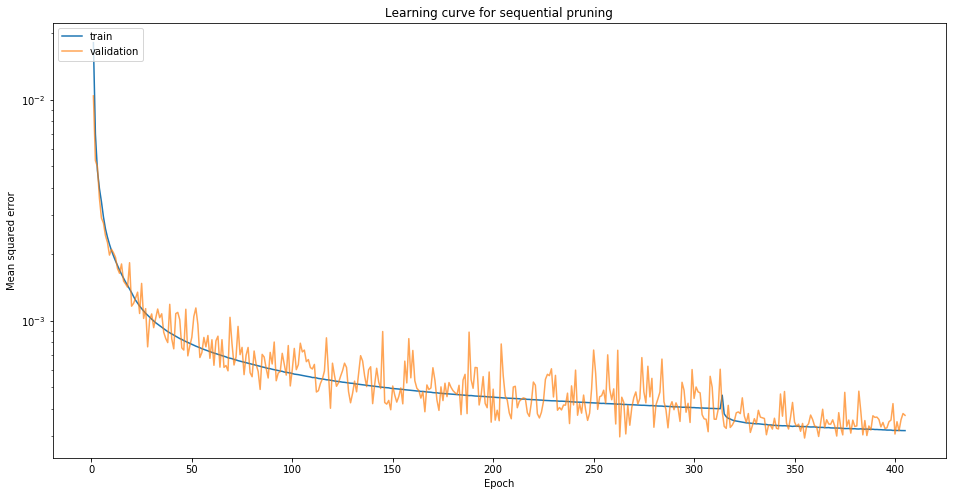

In [32]:
plot_model_history_fromDict(historyDict)
plt.show()

In [53]:
wts = pruned_model.get_weights()
wts3 = wts[-3].reshape(1,16*7)[0]
tot = 0
for i in range(len(wts3)):
    if wts3[i] == 1:
        tot += 1
        
print(tot/(16*17))
    

0.10294117647058823


In [111]:
print("Evaluate on test data")
results = pruned_model.evaluate(Xtest_scaled, Ytest, batch_size=128)
print("test loss, test mse:", results)

Evaluate on test data
5000000/5000000 [==============================] - 87s 17us/sample - loss: 569733111.1408 - mean_squared_error: 569737344.0000
test loss, test acc: [569733111.1407616, 569737340.0]


In [112]:
print("Evaluate on test data")
results = model.evaluate(Xtest_scaled, Ytest, batch_size=128)
print("test loss, test mse:", results)

Evaluate on test data
5000000/5000000 [==============================] - 86s 17us/sample - loss: 569733111.1408 - mean_squared_error: 569737344.0000
test loss, test mse: [569733111.1407616, 569737340.0]


## Sequential pruning

In [37]:
from tensorflow.keras.models import load_model

import tensorflow_model_optimization as tfmot

import tempfile
import os

In [38]:
modelName

'Opt*rmsprop__Dro*0__Num*400*400*400*16__Wei*0_2021_01_25__10_07_47'

In [78]:
K.clear_session()

modelName = 'Opt*rmsprop__Dro*0__Num*400*400*400*16__Wei*0_2021_01_18__12_24_09'
modeltimestamp = "2021_01_18__12_24_09"
model = load_model(os.path.join(modelSubdir,  modelName + ".h5"))

# load history with same name as model
historyFile = modeltimestamp + '_original_history.pkl'
historyDict = pickle.load(open(os.path.join(modelSubdir, historyFile), 'rb'))

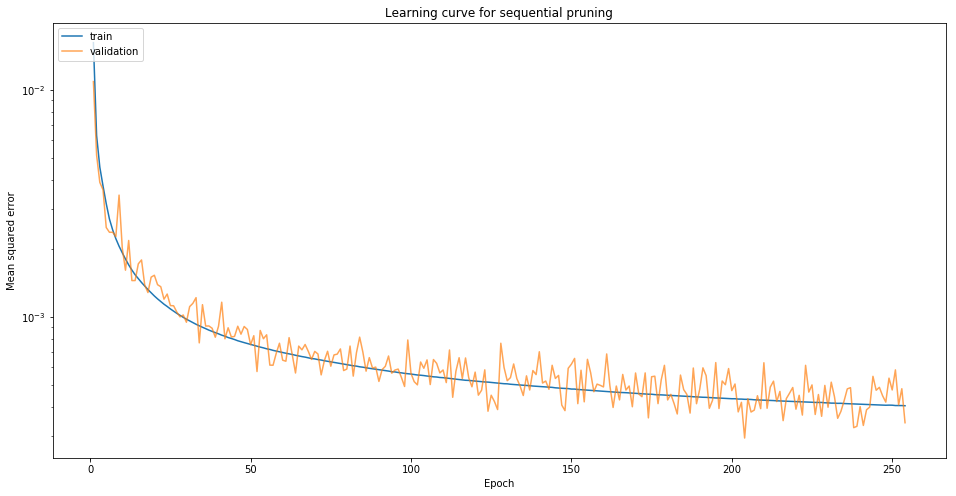

In [39]:
plot_model_history_fromDict(historyDict)
plt.show()

In [40]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
ConstantSparsity = tfmot.sparsity.keras.ConstantSparsity

- iterate through pruning percentages 
- call define pruning parameters on each iteration
- call pruning model function on each iteration
- add history to dictionary on each iteration 

Idea: create function that takes in list of pruning percentages (generated above by Callin's old code). This function will iterate through that list and on each iteration call define_pruning_params and create_pruned_model. Each time, the pruned model should probably be saved, for future analysis of structure after each prune. 

In [88]:
cutPercent = [0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.90]
cutPercent = np.append(cutPercent, np.arange(0.91, 0.99, 0.01))
print(cutPercent)

[0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.9  0.91 0.92 0.93 0.94 0.95
 0.96 0.97 0.98]


In [42]:
# make new folder to save each prune
pruneSubdir = os.path.join(modelSubdir, 'prunes')
if not os.path.exists(pruneSubdir):
    os.mkdir(pruneSubdir)

In [43]:
def sequential_Pruning(model, cutPercent):
    '''
    '''
    
    for i in cutPercent:
        pruning_params = define_pruning_params(i)
        
        #I think this does both a model.load as well as creates the pruned model. Therefore the saved
        #optimizer state is contained here. 
        pruned_model = create_pruned_model(model, pruning_params)
        
        pruned_history = pruned_model.fit(Xtrain_scaled, Ytrain_scaled, 
                                  validation_data=(Xval_scaled, Yval_scaled),
                                  callbacks = callbacks,
                                  verbose = 2, batch_size=2**12, epochs = 500)
        
        historyDict["mean_squared_error"].extend(pruned_history.history['mse'])
        historyDict["val_mean_squared_error"].extend(pruned_history.history['val_mse'])
        
        cut_epochs.append(len(pruned_history.history['mse']) + cut_epochs[-1])

        
        print("************************************** PRUNING", i*100, "% **********************************************")
        print("************************************** PRUNING", i*100, "% **********************************************")
        print("************************************** PRUNING", i*100, "% **********************************************")
        
        p_wts = pruned_model.get_weights()
        
        p_wts = np.array(p_wts)
        p_wts = p_wts.reshape(5,5)
        
        pruned_weights = []
        
        for j in range(len(p_wts)):
            pruned_weights.append(p_wts[j][0])
            pruned_weights.append(p_wts[j][1])
            
        model.set_weights(pruned_weights)
        
        # save model
        model.save(os.path.join(pruneSubdir, str(i) + '_pruned' + '.h5'))
        
    return cut_epochs

In [44]:
start_time = time.time()

#Keep track of which epochs a prune occurs
cut_epochs = [len(historyDict["mean_squared_error"])]

sequential_Pruning(model, cutPercent)

print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Please use `layer.add_weight` method instead.
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 48s - loss: 4.0052e-04 - mse: 4.0052e-04 - val_loss: 3.5951e-04 - val_mse: 3.5951e-04
Epoch 2/500
8000000/8000000 - 47s - loss: 3.9753e-04 - mse: 3.9753e-04 - val_loss: 4.2954e-04 - val_mse: 4.2954e-04
Epoch 3/500
8000000/8000000 - 47s - loss: 3.9660e-04 - mse: 3.9660e-04 - val_loss: 3.8964e-04 - val_mse: 3.8964e-04
Epoch 4/500
8000000/8000000 - 47s - loss: 3.9684e-04 - mse: 3.9684e-04 - val_loss: 4.7981e-04 - val_mse: 4.7981e-04
Epoch 5/500
8000000/8000000 - 47s - loss: 3.9620e-04 - mse: 3.9620e-04 - val_loss: 3.8178e-04 - val_mse: 3.8178e-04
Epoch 6/500
8000000/8000000 - 47s - loss: 3.9530e-04 - mse: 3.9529e-04 - val_loss: 5.1458e-04 - val_mse: 5.1458e-04
Epoch 7/500
8000000/8000000 - 47s - loss: 3.9464e-04 - mse: 3.9464e-04 - val_loss: 4.0684e-04 - val_mse: 4.0684e-04
Epoch 8/500
8000000/8000000 - 47s - loss: 3.9382e-04 - mse: 3

Epoch 68/500
8000000/8000000 - 47s - loss: 3.7306e-04 - mse: 3.7306e-04 - val_loss: 4.2473e-04 - val_mse: 4.2473e-04
Epoch 69/500
8000000/8000000 - 47s - loss: 3.7273e-04 - mse: 3.7273e-04 - val_loss: 4.5418e-04 - val_mse: 4.5418e-04
Epoch 70/500
8000000/8000000 - 47s - loss: 3.7252e-04 - mse: 3.7252e-04 - val_loss: 4.3574e-04 - val_mse: 4.3574e-04
Epoch 71/500
8000000/8000000 - 47s - loss: 3.7186e-04 - mse: 3.7186e-04 - val_loss: 3.7458e-04 - val_mse: 3.7458e-04
Epoch 72/500
8000000/8000000 - 47s - loss: 3.7173e-04 - mse: 3.7173e-04 - val_loss: 4.9021e-04 - val_mse: 4.9021e-04
Epoch 73/500
8000000/8000000 - 47s - loss: 3.7127e-04 - mse: 3.7127e-04 - val_loss: 3.9791e-04 - val_mse: 3.9791e-04
Epoch 74/500
8000000/8000000 - 47s - loss: 3.7091e-04 - mse: 3.7091e-04 - val_loss: 4.5732e-04 - val_mse: 4.5732e-04
Epoch 75/500
8000000/8000000 - 47s - loss: 3.7056e-04 - mse: 3.7056e-04 - val_loss: 5.1920e-04 - val_mse: 5.1920e-04
Epoch 76/500
8000000/8000000 - 47s - loss: 3.7113e-04 - mse: 3.7

/home/olivia/anaconda3/envs/deepLearn_V4/lib/python3.6/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Train on 8000000 samples, validate on 2000000 samples
Epoch 1/500
8000000/8000000 - 48s - loss: 3.5875e-04 - mse: 3.5875e-04 - val_loss: 4.4147e-04 - val_mse: 4.4147e-04
Epoch 2/500
8000000/8000000 - 47s - loss: 3.5735e-04 - mse: 3.5735e-04 - val_loss: 3.3573e-04 - val_mse: 3.3573e-04
Epoch 3/500
8000000/8000000 - 47s - loss: 3.5660e-04 - mse: 3.5660e-04 - val_loss: 4.0396e-04 - val_mse: 4.0396e-04
Epoch 4/500
8000000/8000000 - 47s - loss: 3.5589e-04 - mse: 3.5589e-04 - val_loss: 4.0141e-04 - val_mse: 4.0141e-04
Epoch 5/500
8000000/8000000 - 47s - loss: 3.5579e-04 - mse: 3.5579e-04 - val_loss: 3.7321e-04 - val_mse: 3.7321e-04
Epoch 6/500
8000000/8000000 - 47s - loss: 3.5586e-04 - mse: 3.5586e-04 - val_loss: 3.9037e-04 - val_mse: 3.9037e-04
Epoch 7/500
8000000/8000000 - 47s - loss: 3.5579e-04 - mse: 3.5579e-04 - val_loss: 3.0809e-04 - val_mse: 3.0809e-04
Epoch 8/500
8000000/8000000 - 47s - loss: 3.5492e-04 - mse: 3.5492e-04 - val_loss: 3.5238e-04 - val_mse: 3.5238e-04
Epoch 9/500
800000

Epoch 11/500
8000000/8000000 - 47s - loss: 3.3845e-04 - mse: 3.3845e-04 - val_loss: 3.2541e-04 - val_mse: 3.2541e-04
Epoch 12/500
8000000/8000000 - 47s - loss: 3.3832e-04 - mse: 3.3832e-04 - val_loss: 4.6462e-04 - val_mse: 4.6462e-04
Epoch 13/500
8000000/8000000 - 47s - loss: 3.3799e-04 - mse: 3.3799e-04 - val_loss: 4.1461e-04 - val_mse: 4.1461e-04
Epoch 14/500
8000000/8000000 - 47s - loss: 3.3779e-04 - mse: 3.3779e-04 - val_loss: 3.4311e-04 - val_mse: 3.4311e-04
Epoch 15/500
8000000/8000000 - 47s - loss: 3.3706e-04 - mse: 3.3706e-04 - val_loss: 2.8752e-04 - val_mse: 2.8752e-04
Epoch 16/500
8000000/8000000 - 47s - loss: 3.3685e-04 - mse: 3.3685e-04 - val_loss: 4.2344e-04 - val_mse: 4.2344e-04
Epoch 17/500
8000000/8000000 - 47s - loss: 3.3682e-04 - mse: 3.3682e-04 - val_loss: 4.3458e-04 - val_mse: 4.3458e-04
Epoch 18/500
8000000/8000000 - 47s - loss: 3.3734e-04 - mse: 3.3734e-04 - val_loss: 4.2621e-04 - val_mse: 4.2621e-04
Epoch 19/500
8000000/8000000 - 47s - loss: 3.3677e-04 - mse: 3.3

Epoch 25/500
8000000/8000000 - 47s - loss: 3.2387e-04 - mse: 3.2387e-04 - val_loss: 2.9905e-04 - val_mse: 2.9905e-04
Epoch 26/500
8000000/8000000 - 47s - loss: 3.2426e-04 - mse: 3.2426e-04 - val_loss: 2.7018e-04 - val_mse: 2.7018e-04
Epoch 27/500
8000000/8000000 - 47s - loss: 3.2389e-04 - mse: 3.2389e-04 - val_loss: 2.6623e-04 - val_mse: 2.6623e-04
Epoch 28/500
8000000/8000000 - 47s - loss: 3.2310e-04 - mse: 3.2310e-04 - val_loss: 3.5550e-04 - val_mse: 3.5550e-04
Epoch 29/500
8000000/8000000 - 47s - loss: 3.2295e-04 - mse: 3.2295e-04 - val_loss: 4.0774e-04 - val_mse: 4.0774e-04
Epoch 30/500
8000000/8000000 - 47s - loss: 3.2305e-04 - mse: 3.2305e-04 - val_loss: 4.5049e-04 - val_mse: 4.5049e-04
Epoch 31/500
8000000/8000000 - 47s - loss: 3.2315e-04 - mse: 3.2315e-04 - val_loss: 3.6293e-04 - val_mse: 3.6293e-04
Epoch 32/500
8000000/8000000 - 47s - loss: 3.2284e-04 - mse: 3.2284e-04 - val_loss: 3.2430e-04 - val_mse: 3.2430e-04
Epoch 33/500
8000000/8000000 - 47s - loss: 3.2270e-04 - mse: 3.2

Epoch 30/500
8000000/8000000 - 47s - loss: 3.0938e-04 - mse: 3.0938e-04 - val_loss: 3.1206e-04 - val_mse: 3.1206e-04
Epoch 31/500
8000000/8000000 - 47s - loss: 3.0963e-04 - mse: 3.0963e-04 - val_loss: 3.0391e-04 - val_mse: 3.0391e-04
Epoch 32/500
8000000/8000000 - 47s - loss: 3.0930e-04 - mse: 3.0930e-04 - val_loss: 2.7723e-04 - val_mse: 2.7723e-04
Epoch 33/500
8000000/8000000 - 47s - loss: 3.0913e-04 - mse: 3.0913e-04 - val_loss: 2.8349e-04 - val_mse: 2.8349e-04
Epoch 34/500
8000000/8000000 - 47s - loss: 3.0847e-04 - mse: 3.0847e-04 - val_loss: 3.0588e-04 - val_mse: 3.0588e-04
Epoch 35/500
8000000/8000000 - 47s - loss: 3.0959e-04 - mse: 3.0959e-04 - val_loss: 2.9065e-04 - val_mse: 2.9065e-04
Epoch 36/500
8000000/8000000 - 47s - loss: 3.0784e-04 - mse: 3.0783e-04 - val_loss: 2.9189e-04 - val_mse: 2.9189e-04
Epoch 37/500
8000000/8000000 - 47s - loss: 3.0841e-04 - mse: 3.0841e-04 - val_loss: 4.0295e-04 - val_mse: 4.0295e-04
Epoch 38/500
8000000/8000000 - 47s - loss: 3.0863e-04 - mse: 3.0

Epoch 35/500
8000000/8000000 - 47s - loss: 2.9941e-04 - mse: 2.9941e-04 - val_loss: 3.7766e-04 - val_mse: 3.7766e-04
Epoch 36/500
8000000/8000000 - 47s - loss: 2.9966e-04 - mse: 2.9966e-04 - val_loss: 3.3657e-04 - val_mse: 3.3657e-04
Epoch 37/500
8000000/8000000 - 47s - loss: 2.9913e-04 - mse: 2.9913e-04 - val_loss: 4.0827e-04 - val_mse: 4.0827e-04
Epoch 38/500
8000000/8000000 - 47s - loss: 2.9870e-04 - mse: 2.9870e-04 - val_loss: 3.0348e-04 - val_mse: 3.0348e-04
Epoch 39/500
8000000/8000000 - 47s - loss: 2.9878e-04 - mse: 2.9878e-04 - val_loss: 3.3341e-04 - val_mse: 3.3341e-04
Epoch 40/500
8000000/8000000 - 47s - loss: 2.9878e-04 - mse: 2.9878e-04 - val_loss: 3.3075e-04 - val_mse: 3.3075e-04
Epoch 41/500
8000000/8000000 - 47s - loss: 2.9910e-04 - mse: 2.9910e-04 - val_loss: 3.0163e-04 - val_mse: 3.0163e-04
Epoch 42/500
8000000/8000000 - 47s - loss: 2.9819e-04 - mse: 2.9819e-04 - val_loss: 3.1292e-04 - val_mse: 3.1292e-04
Epoch 43/500
8000000/8000000 - 47s - loss: 2.9860e-04 - mse: 2.9

Epoch 105/500
8000000/8000000 - 47s - loss: 2.9318e-04 - mse: 2.9318e-04 - val_loss: 4.3106e-04 - val_mse: 4.3107e-04
Epoch 106/500
8000000/8000000 - 47s - loss: 2.9330e-04 - mse: 2.9330e-04 - val_loss: 3.1205e-04 - val_mse: 3.1205e-04
Epoch 107/500
8000000/8000000 - 47s - loss: 2.9239e-04 - mse: 2.9239e-04 - val_loss: 2.6918e-04 - val_mse: 2.6918e-04
Epoch 108/500
8000000/8000000 - 47s - loss: 2.9285e-04 - mse: 2.9285e-04 - val_loss: 2.4890e-04 - val_mse: 2.4890e-04
Epoch 109/500
8000000/8000000 - 47s - loss: 2.9220e-04 - mse: 2.9220e-04 - val_loss: 2.8534e-04 - val_mse: 2.8534e-04
Epoch 110/500
8000000/8000000 - 47s - loss: 2.9239e-04 - mse: 2.9239e-04 - val_loss: 3.1594e-04 - val_mse: 3.1594e-04
Epoch 111/500
8000000/8000000 - 47s - loss: 2.9226e-04 - mse: 2.9226e-04 - val_loss: 2.8341e-04 - val_mse: 2.8341e-04
Epoch 112/500
8000000/8000000 - 47s - loss: 2.9229e-04 - mse: 2.9229e-04 - val_loss: 2.9502e-04 - val_mse: 2.9502e-04
Epoch 113/500
8000000/8000000 - 47s - loss: 2.9246e-04 -

Epoch 20/500
8000000/8000000 - 47s - loss: 2.8496e-04 - mse: 2.8496e-04 - val_loss: 2.8771e-04 - val_mse: 2.8771e-04
Epoch 21/500
8000000/8000000 - 47s - loss: 2.8490e-04 - mse: 2.8490e-04 - val_loss: 2.9606e-04 - val_mse: 2.9606e-04
Epoch 22/500
8000000/8000000 - 47s - loss: 2.8490e-04 - mse: 2.8490e-04 - val_loss: 2.9028e-04 - val_mse: 2.9028e-04
Epoch 23/500
8000000/8000000 - 47s - loss: 2.8456e-04 - mse: 2.8456e-04 - val_loss: 3.1920e-04 - val_mse: 3.1920e-04
Epoch 24/500
8000000/8000000 - 47s - loss: 2.8456e-04 - mse: 2.8456e-04 - val_loss: 3.2322e-04 - val_mse: 3.2322e-04
Epoch 25/500
8000000/8000000 - 47s - loss: 2.8447e-04 - mse: 2.8447e-04 - val_loss: 2.6172e-04 - val_mse: 2.6172e-04
Epoch 26/500
8000000/8000000 - 47s - loss: 2.8411e-04 - mse: 2.8411e-04 - val_loss: 3.0526e-04 - val_mse: 3.0526e-04
Epoch 27/500
8000000/8000000 - 47s - loss: 2.8383e-04 - mse: 2.8383e-04 - val_loss: 2.8419e-04 - val_mse: 2.8419e-04
Epoch 28/500
8000000/8000000 - 47s - loss: 2.8453e-04 - mse: 2.8

Epoch 3/500
8000000/8000000 - 47s - loss: 3.1951e-04 - mse: 3.1951e-04 - val_loss: 3.0550e-04 - val_mse: 3.0550e-04
Epoch 4/500
8000000/8000000 - 47s - loss: 3.1447e-04 - mse: 3.1447e-04 - val_loss: 2.9573e-04 - val_mse: 2.9573e-04
Epoch 5/500
8000000/8000000 - 47s - loss: 3.1031e-04 - mse: 3.1031e-04 - val_loss: 3.8552e-04 - val_mse: 3.8552e-04
Epoch 6/500
8000000/8000000 - 47s - loss: 3.0750e-04 - mse: 3.0750e-04 - val_loss: 3.7113e-04 - val_mse: 3.7113e-04
Epoch 7/500
8000000/8000000 - 47s - loss: 3.0580e-04 - mse: 3.0580e-04 - val_loss: 3.4416e-04 - val_mse: 3.4416e-04
Epoch 8/500
8000000/8000000 - 47s - loss: 3.0285e-04 - mse: 3.0285e-04 - val_loss: 3.4752e-04 - val_mse: 3.4752e-04
Epoch 9/500
8000000/8000000 - 47s - loss: 3.0082e-04 - mse: 3.0082e-04 - val_loss: 3.5572e-04 - val_mse: 3.5572e-04
Epoch 10/500
8000000/8000000 - 47s - loss: 2.9964e-04 - mse: 2.9964e-04 - val_loss: 3.4426e-04 - val_mse: 3.4426e-04
Epoch 11/500
8000000/8000000 - 47s - loss: 2.9855e-04 - mse: 2.9855e-04

8000000/8000000 - 47s - loss: 2.8037e-04 - mse: 2.8037e-04 - val_loss: 2.6739e-04 - val_mse: 2.6739e-04
Epoch 74/500
8000000/8000000 - 47s - loss: 2.8071e-04 - mse: 2.8071e-04 - val_loss: 3.0527e-04 - val_mse: 3.0527e-04
Epoch 75/500
8000000/8000000 - 47s - loss: 2.8047e-04 - mse: 2.8047e-04 - val_loss: 2.8321e-04 - val_mse: 2.8321e-04
Epoch 76/500
8000000/8000000 - 47s - loss: 2.8034e-04 - mse: 2.8034e-04 - val_loss: 3.4412e-04 - val_mse: 3.4412e-04
Epoch 77/500
8000000/8000000 - 47s - loss: 2.8058e-04 - mse: 2.8058e-04 - val_loss: 3.0342e-04 - val_mse: 3.0342e-04
Epoch 78/500
8000000/8000000 - 47s - loss: 2.8040e-04 - mse: 2.8040e-04 - val_loss: 3.0421e-04 - val_mse: 3.0421e-04
Epoch 79/500
8000000/8000000 - 47s - loss: 2.7998e-04 - mse: 2.7998e-04 - val_loss: 2.8533e-04 - val_mse: 2.8533e-04
Epoch 80/500
8000000/8000000 - 47s - loss: 2.8014e-04 - mse: 2.8014e-04 - val_loss: 3.1015e-04 - val_mse: 3.1015e-04
Epoch 81/500
8000000/8000000 - 47s - loss: 2.7973e-04 - mse: 2.7973e-04 - val

Epoch 3/500
8000000/8000000 - 47s - loss: 3.8524e-04 - mse: 3.8524e-04 - val_loss: 3.7405e-04 - val_mse: 3.7405e-04
Epoch 4/500
8000000/8000000 - 47s - loss: 3.6763e-04 - mse: 3.6763e-04 - val_loss: 4.3372e-04 - val_mse: 4.3372e-04
Epoch 5/500
8000000/8000000 - 47s - loss: 3.5596e-04 - mse: 3.5596e-04 - val_loss: 3.6536e-04 - val_mse: 3.6536e-04
Epoch 6/500
8000000/8000000 - 47s - loss: 3.4769e-04 - mse: 3.4769e-04 - val_loss: 3.8277e-04 - val_mse: 3.8277e-04
Epoch 7/500
8000000/8000000 - 47s - loss: 3.4078e-04 - mse: 3.4078e-04 - val_loss: 3.3494e-04 - val_mse: 3.3494e-04
Epoch 8/500
8000000/8000000 - 47s - loss: 3.3524e-04 - mse: 3.3524e-04 - val_loss: 3.9766e-04 - val_mse: 3.9766e-04
Epoch 9/500
8000000/8000000 - 47s - loss: 3.3042e-04 - mse: 3.3042e-04 - val_loss: 3.8847e-04 - val_mse: 3.8847e-04
Epoch 10/500
8000000/8000000 - 47s - loss: 3.2725e-04 - mse: 3.2725e-04 - val_loss: 3.1755e-04 - val_mse: 3.1755e-04
Epoch 11/500
8000000/8000000 - 47s - loss: 3.2368e-04 - mse: 3.2368e-04

8000000/8000000 - 47s - loss: 2.7603e-04 - mse: 2.7603e-04 - val_loss: 3.1778e-04 - val_mse: 3.1778e-04
Epoch 74/500
8000000/8000000 - 47s - loss: 2.7553e-04 - mse: 2.7553e-04 - val_loss: 2.9253e-04 - val_mse: 2.9253e-04
Epoch 75/500
8000000/8000000 - 47s - loss: 2.7560e-04 - mse: 2.7560e-04 - val_loss: 3.1976e-04 - val_mse: 3.1976e-04
Epoch 76/500
8000000/8000000 - 47s - loss: 2.7553e-04 - mse: 2.7553e-04 - val_loss: 3.3140e-04 - val_mse: 3.3140e-04
Epoch 77/500
8000000/8000000 - 47s - loss: 2.7501e-04 - mse: 2.7501e-04 - val_loss: 3.1254e-04 - val_mse: 3.1254e-04
Epoch 78/500
8000000/8000000 - 47s - loss: 2.7461e-04 - mse: 2.7461e-04 - val_loss: 2.8518e-04 - val_mse: 2.8518e-04
Epoch 79/500
8000000/8000000 - 47s - loss: 2.7416e-04 - mse: 2.7416e-04 - val_loss: 2.7303e-04 - val_mse: 2.7303e-04
Epoch 80/500
8000000/8000000 - 47s - loss: 2.7399e-04 - mse: 2.7399e-04 - val_loss: 3.1720e-04 - val_mse: 3.1720e-04
Epoch 81/500
8000000/8000000 - 47s - loss: 2.7401e-04 - mse: 2.7401e-04 - val

Epoch 45/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 46/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 47/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 48/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 49/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 50/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 51/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 52/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 53/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 54/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_ms

Epoch 58/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 59/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 60/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 61/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 62/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 63/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 64/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 65/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 66/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 67/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_ms

Epoch 139/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 140/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 141/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 142/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 143/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 144/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 145/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 146/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 147/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 148/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.004

Epoch 220/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 221/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 222/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 223/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 224/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 225/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 226/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 227/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 228/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 229/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.004

8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 45/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 46/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 47/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 48/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 49/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 50/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 51/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 52/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 53/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epo

Epoch 33/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 34/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 35/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 36/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 37/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 38/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 39/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 40/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 41/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 42/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0040 - val_ms

Epoch 13/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 14/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 15/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 16/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 17/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 18/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 19/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 20/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 21/500
8000000/8000000 - 47s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 22/500
8000000/8000000 - 47s - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0042 - val_ms

8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 95/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 96/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 97/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 98/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 99/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 100/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 101/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 102/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 103/500
8000000/8000000 - 47s - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0040 - val_mse: 0.0040

Epoch 58/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 59/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 60/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 61/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 62/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 63/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 64/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 65/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 66/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 67/500
8000000/8000000 - 47s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0158 - val_ms

Epoch 15/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 16/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 17/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 18/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 19/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 20/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 21/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 22/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 23/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 24/500
8000000/8000000 - 47s - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0196 - val_ms

8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 37/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 38/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 39/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 40/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 41/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 42/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 43/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 44/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 45/500
8000000/8000000 - 47s - loss: 0.0261 - mse: 0.0261 - val_loss: 0.0261 - val_mse: 0.0261
Epo

In [45]:
# save history with same name as model
historyFile = modeltimestamp + '_pruned_history.pkl'
pickle.dump(historyDict, open(os.path.join(modelSubdir, historyFile), 'wb'))

prune_timestamps = modeltimestamp + '_pune_timestamps'
pickle.dump(cut_epochs, open(os.path.join(modelSubdir, prune_timestamps), 'wb'))

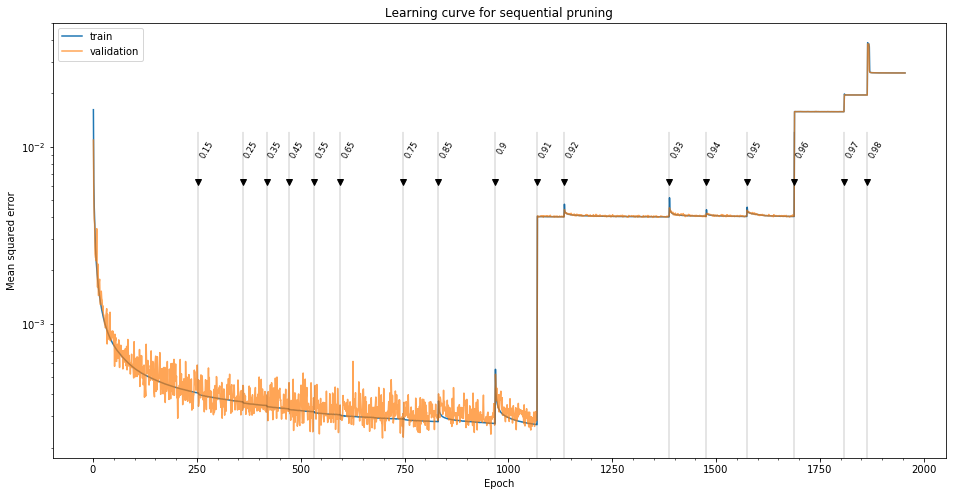

In [46]:
plot_model_history_fromDict(historyDict)

for i in range(len(cut_epochs)-1):
    plt.axvline(x=cut_epochs[i],ymax=0.75,color='k',linewidth=.2)
    plt.plot(cut_epochs[i],10**-2.2, "v", color = "black")
    
for i in range(0,len(cut_epochs)-1):
    plt.text(cut_epochs[i],0.01,round(cutPercent[i],4),rotation=60,fontsize='small')
    
plt.show()

## Build connection txt file

In [25]:
modeltimestamp = "2021_01_25__10_07_47"

# load history with same name as model
historyFile = '2021_01_25__10_07_47_pruned_history.pkl'
historyDict_OT_prune = pickle.load(open(os.path.join(dataOutput, modeltimestamp, historyFile), 'rb'))

epochFile = '2021_01_25__10_07_47_pune_timestamps'
cut_epochs = pickle.load(open(os.path.join(dataOutput, modeltimestamp, epochFile), 'rb'))

Text(2100,0.00103,'Hypothetical noise threshold')

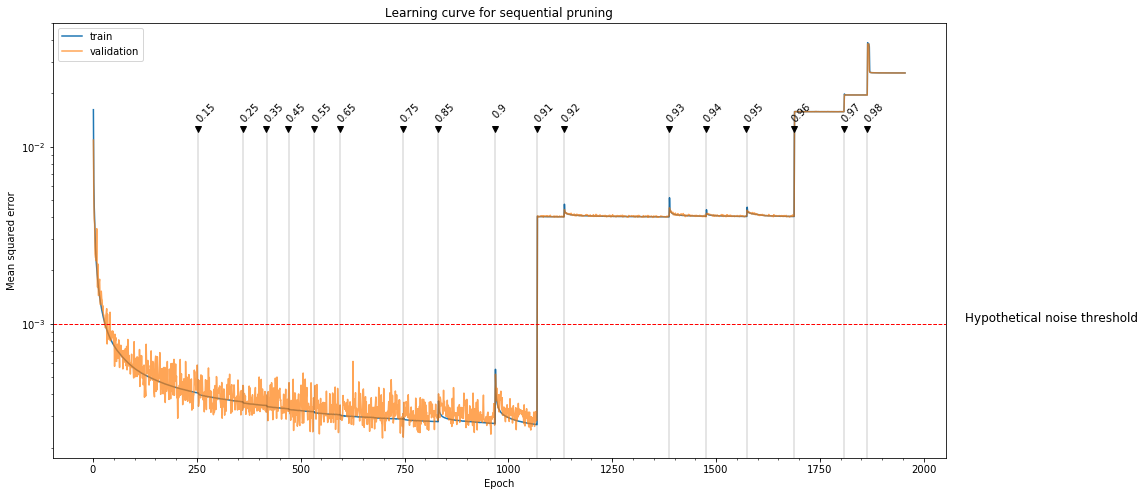

In [26]:
plot_model_history_fromDict(historyDict_OT_prune)

for i in range(len(cut_epochs)-1):
    plt.axvline(x=cut_epochs[i],ymax=0.75,color='k',linewidth=.2)
    plt.plot(cut_epochs[i]-1,10**-1.9, "v", color = "black")
    
for i in range(0,len(cut_epochs)-1):
    plt.text(cut_epochs[i]-10,10**-1.79,round(cutPercent[i],4),rotation=45,fontsize='medium')
    
plt.axhline(0.001, linestyle= '--',linewidth=1, color='r')
plt.text(2100, 0.00103, 'Hypothetical noise threshold',fontsize='large')

#### Load in the pruned model

In [72]:
from tensorflow.keras.models import load_model
prune = '0.9400000000000001_pruned'
model = load_model(os.path.join(dataOutput, modeltimestamp, 'prunes', prune + ".h5"))

In [73]:
wts = model.get_weights()

#Take only the weight matrices, leaving out the bias matrices
arrs = wts[::2]

In [74]:
netX = np.array([])
netY = np.array([])

count = 1
for a in arrs:
    idx = np.nonzero(a)
    x = idx[0]+count
    count += a.shape[0]
    y = idx[1]+count
    netX = np.concatenate((netX,x)).astype(int)
    netY = np.concatenate((netY,y)).astype(int)
    
netX = netX.tolist()
netY = netY.tolist()

In [75]:
connect = zip(netX, netY)
connect = set(connect) 
connect = sorted(connect)

print(connect)

[(1, 49), (1, 53), (1, 63), (1, 86), (1, 87), (1, 141), (1, 201), (1, 203), (1, 205), (1, 207), (1, 224), (1, 244), (1, 245), (1, 250), (1, 262), (1, 264), (1, 280), (1, 283), (1, 312), (1, 325), (1, 335), (1, 339), (1, 345), (1, 359), (1, 360), (1, 362), (1, 372), (1, 380), (1, 384), (1, 397), (1, 400), (2, 42), (2, 49), (2, 53), (2, 63), (2, 86), (2, 87), (2, 201), (2, 203), (2, 205), (2, 224), (2, 227), (2, 244), (2, 245), (2, 250), (2, 262), (2, 264), (2, 280), (2, 283), (2, 312), (2, 321), (2, 335), (2, 339), (2, 345), (2, 359), (2, 360), (2, 362), (2, 372), (2, 380), (2, 397), (2, 400), (3, 201), (3, 203), (3, 207), (3, 224), (3, 244), (3, 245), (3, 280), (3, 335), (3, 345), (3, 359), (3, 360), (3, 384), (3, 400), (4, 63), (4, 201), (4, 215), (4, 224), (4, 244), (4, 245), (4, 264), (4, 266), (4, 280), (4, 339), (4, 359), (4, 360), (4, 362), (4, 372), (4, 384), (4, 400), (5, 49), (5, 53), (5, 63), (5, 86), (5, 87), (5, 141), (5, 154), (5, 201), (5, 203), (5, 205), (5, 207), (5, 22

In [85]:
numEdges = len(connect)
numVertices = 10 + 400 + 400 + 400 + 16 +7

connect.insert(0, (numVertices, numEdges))

In [86]:
print(connect)

[(1233, 19831), (1, 49), (1, 53), (1, 63), (1, 86), (1, 87), (1, 141), (1, 201), (1, 203), (1, 205), (1, 207), (1, 224), (1, 244), (1, 245), (1, 250), (1, 262), (1, 264), (1, 280), (1, 283), (1, 312), (1, 325), (1, 335), (1, 339), (1, 345), (1, 359), (1, 360), (1, 362), (1, 372), (1, 380), (1, 384), (1, 397), (1, 400), (2, 42), (2, 49), (2, 53), (2, 63), (2, 86), (2, 87), (2, 201), (2, 203), (2, 205), (2, 224), (2, 227), (2, 244), (2, 245), (2, 250), (2, 262), (2, 264), (2, 280), (2, 283), (2, 312), (2, 321), (2, 335), (2, 339), (2, 345), (2, 359), (2, 360), (2, 362), (2, 372), (2, 380), (2, 397), (2, 400), (3, 201), (3, 203), (3, 207), (3, 224), (3, 244), (3, 245), (3, 280), (3, 335), (3, 345), (3, 359), (3, 360), (3, 384), (3, 400), (4, 63), (4, 201), (4, 215), (4, 224), (4, 244), (4, 245), (4, 264), (4, 266), (4, 280), (4, 339), (4, 359), (4, 360), (4, 362), (4, 372), (4, 384), (4, 400), (5, 49), (5, 53), (5, 63), (5, 86), (5, 87), (5, 141), (5, 154), (5, 201), (5, 203), (5, 205), (

In [87]:
with open(os.path.join(dataOutput, modeltimestamp, 'prunes', modeltimestamp + '_' + prune + '.txt'), 'w') as f:
    for item in connect:
        final = ' '.join(str(i) for i in item)
        f.write("%s\n" % final)

## Figure Creation

Load both pruned models 

### Callin's Model

In [77]:
K.clear_session()

modeltimestamp = '2020_11_25__07_53_11'

# load history with same name as model
historyFile = '2020_11_25__07_53_11_CallinPruned_history.pkl'
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpointsCS")
historyDict_CS_prune = pickle.load(open(os.path.join(modelSubdir, historyFile), 'rb'))

# load prune timestamps
# Callin's method for saving the pruning epochs
savedChecks = [f for f in os.listdir(os.path.join(savedModels, modelSubdir)) if f.endswith('wts.pkl')]
vlines = [int(savedChecks[ii][0:4].replace("_", "")) for ii in range(len(savedChecks)) if savedChecks[ii][0].isdigit()]

'\nfor i in range(len(vlines)-1):\n    plt.axvline(x=vlines[i],ymax=0.75,color=\'k\',linewidth=.2)\n    plt.plot(vlines[i],10**-2, "v", color = "black")\n    \nvlines.sort()\n    \nfor i in range(0,len(vlines)-1):\n    if i > 4:\n        plt.text(vlines[i],0.017,round(cutPercent[i],4),rotation=60,fontsize=\'small\')\n        \nplt.axhline(0.001, linestyle= \'--\',linewidth=2, color=\'r\')\nplt.text(150, 0.00105, \'Hypothetical noise threshold\')\n'

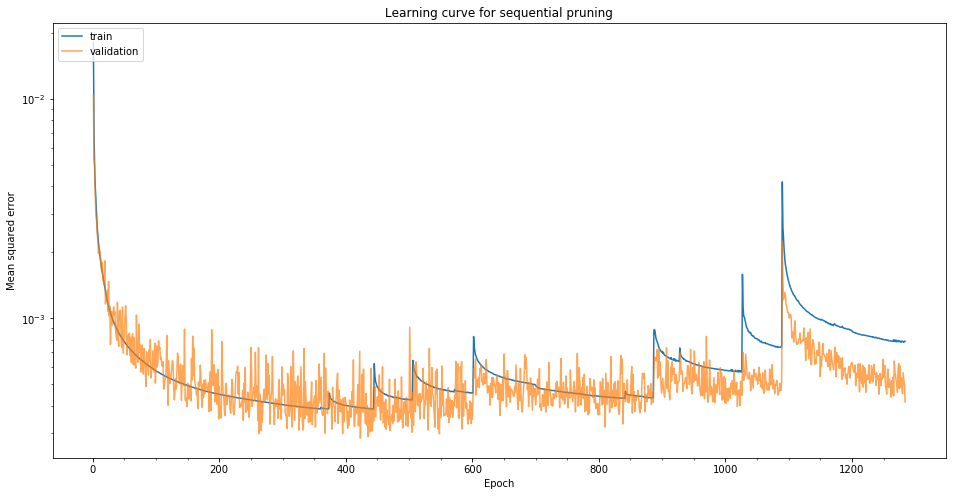

In [79]:
plot_model_history_fromDict(historyDict_CS_prune)
'''
for i in range(len(vlines)-1):
    plt.axvline(x=vlines[i],ymax=0.75,color='k',linewidth=.2)
    plt.plot(vlines[i],10**-2, "v", color = "black")
    
vlines.sort()
    
for i in range(0,len(vlines)-1):
    if i > 4:
        plt.text(vlines[i],0.017,round(cutPercent[i],4),rotation=60,fontsize='small')
        
plt.axhline(0.001, linestyle= '--',linewidth=2, color='r')
plt.text(150, 0.00105, 'Hypothetical noise threshold')
'''

In [22]:
modeltimestamp = "2020_11_25__07_53_11"


# load history with same name as model
historyFile = '2020_11_25__07_53_11_earlystop_0.0001_pruned_history.pkl'
historyDict_OT_prune = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))

epochFile = '2020_11_25__07_53_11_earlystop_0.0001_pune_timestamps'
cut_epochs = pickle.load(open(os.path.join(dataOutput, epochFile), 'rb'))

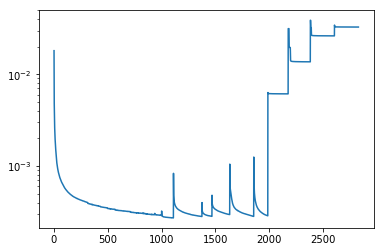

In [76]:
plt.plot(historyDict_OT_prune['mean_squared_error'])
plt.yscale('log') #logarithmic scale for y axis


Text(2100,0.00103,'Hypothetical noise threshold')

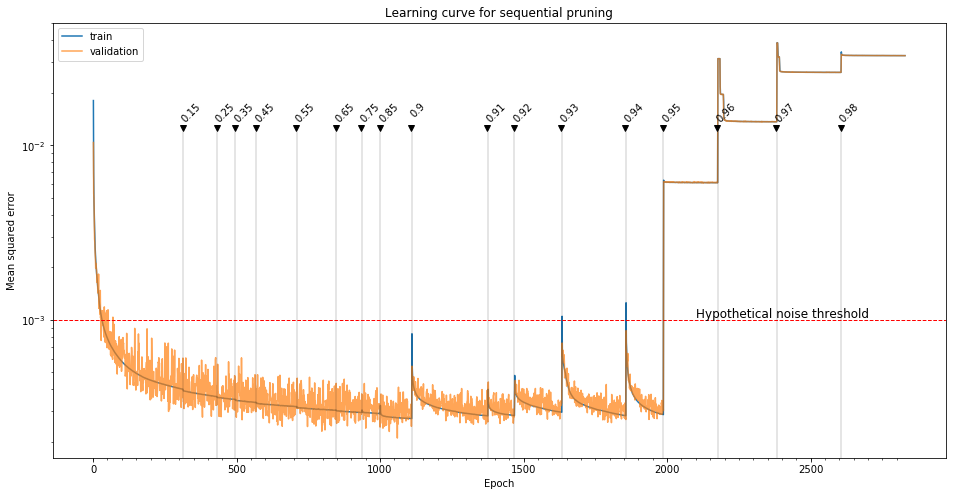

In [73]:
plot_model_history_fromDict(historyDict_OT_prune)

for i in range(len(cut_epochs)-1):
    plt.axvline(x=cut_epochs[i],ymax=0.75,color='k',linewidth=.2)
    plt.plot(cut_epochs[i]-1,10**-1.9, "v", color = "black")
    
for i in range(0,len(cut_epochs)-1):
    plt.text(cut_epochs[i]-10,10**-1.79,round(cutPercent[i],4),rotation=45,fontsize='medium')
    
plt.axhline(0.001, linestyle= '--',linewidth=1, color='r')
plt.text(2100, 0.00103, 'Hypothetical noise threshold',fontsize='large')
#plt.grid(True, which="both")

In [69]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-5967.453613,17690.990234,-48919.882812,-580.231506,-1343.035034,-114.036430,-118.226456
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-5309.352539,5041.308105,-60412.925781,-1.199094,1383.986938,-4.115515,-8.734145
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-10475.754883,-16107.546875,-47557.539062,-1136.972900,-1391.377197,144.275894,139.078659
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,22148.250000,-6499.242676,67265.007812,-273.286438,-550.424805,135.582123,130.418793
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,3927.504150,6896.766113,32134.501953,647.107727,-55.471333,9.455336,4.783791


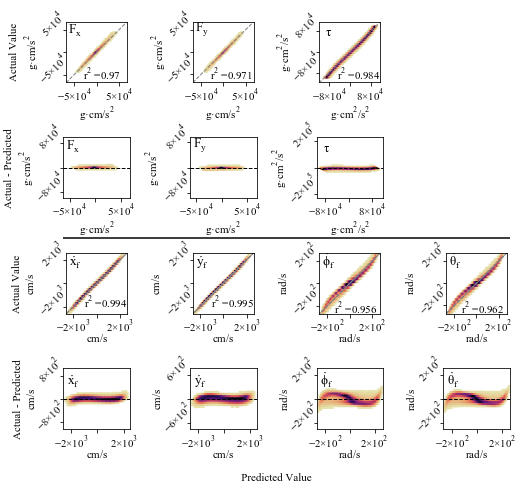

In [70]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.3)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.3)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.75, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)############################
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.47,0.47], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
fig.savefig(os.path.join(figDir, "PredVActual" + modelName + "PRUNED.pdf"),)
plt.show()
# plt.close()

In [83]:
lst = [[1,0,1],[1,1,0]]
arr = np.array(lst)

In [84]:
lst1 = [[1,0,1],[1,1,0],[0,1,0]]
arr1 = np.array(lst1)

In [85]:
lst2 = [[0,0],[1,0],[1,1]]
arr2 = np.array(lst2)

In [89]:
arrs = [arr, arr1, arr2]

In [123]:
netX = np.array([])
netY = np.array([])

count = 1
for a in arrs:
    idx = np.nonzero(a)
    x = idx[0]+count
    count += a.shape[0]
    y = idx[1]+count
    netX = np.concatenate((netX,x)).astype(int)
    netY = np.concatenate((netY,y)).astype(int)
    
netX = netX.tolist()
netY = netY.tolist()

In [124]:
connect = zip(netX, netY)

In [126]:
connect = set(connect) 

In [129]:
print(sorted(connect))

[(1, 3), (1, 5), (2, 3), (2, 4), (3, 6), (3, 8), (4, 6), (4, 7), (5, 7), (7, 9), (8, 9), (8, 10)]
